In [1]:
using Revise

In [2]:
using Distributed
procs_to_use = 10

if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end
;

In [3]:
@everywhere using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    StructArrays,
    StaticArrays,
    LoopVectorization,
    Parameters

## Define molecular states for the laser cooling transition

### Define Hamiltonian for the CaOH $\widetilde{X}^2\Sigma^+(N=1)$ state

In [4]:
@everywhere begin
    
    # Define constants for the laser cooling transition
    @consts begin
        λ = 626e-9             # wavelength of transition
        Γ = 2π * 6.4e6         # transition linewidth
        m = @with_unit 57 "u"  # mass of CaOH
        k = 2π / λ             # wavenumber of transition
    end
    
    # Define a Hund's case (b) basis for the Hamiltonian, using states from N=0 to N=3
    QN_bounds = (
        label = "X",
        S = 1/2, 
        I = 1/2, 
        Λ = 0, 
        N = 0:3
    )
    X_state_basis = order_basis_by_m(enumerate_states(HundsCaseB_LinearMolecule, QN_bounds))
    # X_state_basis = enumerate_states(HundsCaseB_LinearMolecule, QN_bounds)
    
    # Define the operator for the X state Hamiltonian of CaOH
    X_state_operator = :(
        BX * Rotation + 
        DX * RotationDistortion + 
        γX * SpinRotation + 
        bFX * Hyperfine_IS + 
        cX * (Hyperfine_Dipolar/3)
    )
    
    X_state_parameters = QuantumStates.@params begin
        # BX = 10023.0841 * 1e6
        # DX = 1.154e-2 * 1e6
        # γX = 34.7593 * 1e6
        # bFX = 2.602 * 1e6
        # cX = 2.053 * 1e6
        BX = 10023.0841
        DX = 1.154e-2
        γX = 34.7593
        bFX = 2.602
        cX = 2.053
    end
    
    X_state_ham = Hamiltonian(basis=X_state_basis, operator=X_state_operator, parameters=X_state_parameters)
    
    # Add Zeeman terms
    Zeeman_x(state, state′) = (Zeeman(state, state′,-1) - Zeeman(state, state′,1))/sqrt(2)
    Zeeman_y(state, state′) = im*(Zeeman(state, state′,-1) + Zeeman(state, state′,1))/sqrt(2)
    Zeeman_z(state, state′) = Zeeman(state, state′, 0)
    
    # X_state_ham = add_to_H(X_state_ham, :B_x, gS * μB * Zeeman_x)
    # X_state_ham = add_to_H(X_state_ham, :B_y, gS * μB * Zeeman_y)
    # X_state_ham = add_to_H(X_state_ham, :B_z, gS * μB * Zeeman_z)
    
    evaluate!(X_state_ham)
    QuantumStates.solve!(X_state_ham)
end

### Define Hamiltonian for the CaOH $\widetilde{A}^2\Pi_{1/2}(J=1/2+)$ state

In [5]:
@everywhere begin
    QN_bounds = (
        label = "A",
        S = 1/2,
        I = 1/2,
        Λ = (-1,1),
        J = 1/2:5/2
    )
    # A_state_basis = order_basis_by_m(enumerate_states(HundsCaseA_LinearMolecule, QN_bounds))
    A_state_basis = enumerate_states(HundsCaseA_LinearMolecule, QN_bounds)
    
    A_state_operator = :(
        T_A * DiagonalOperator +
        Be_A * Rotation + 
        Aso_A * SpinOrbit +
        q_A * ΛDoubling_q +
        p_A * ΛDoubling_p2q + q_A * (2ΛDoubling_p2q)
    )
    
    # Spectroscopic constants for CaOH, A state
    A_state_parameters = QuantumStates.@params begin
        # T_A = 15998.122 * c * 1e2
        # Be_A = 0.3412200 * c * 1e2
        # Aso_A = 66.8181 * c * 1e2
        # p_A = -0.04287 * c * 1e2
        # q_A = -0.3257e-3 * c * 1e2
        T_A = 15998.122 * c * 1e-4
        Be_A = 0.3412200 * c * 1e-4
        Aso_A = 66.8181 * c * 1e-4
        p_A = -0.04287 * c * 1e-4
        q_A = -0.3257e-3 * c * 1e-4
    end
    
    A_state_ham_caseA = Hamiltonian(basis=A_state_basis, operator=A_state_operator, parameters=A_state_parameters)
    evaluate!(A_state_ham_caseA)
    QuantumStates.solve!(A_state_ham_caseA)
    
    # Convert A state from Hund's case (b) to Hund's case (a)
    # QN_bounds = (
    #     label = "A",
    #     S = 1/2, 
    #     I = 1/2, 
    #     Λ = (-1,1), 
    #     N = 0:3,
    #     J = 1/2:5/2
    # )
    QN_bounds = (
        label = "A",
        S = 1/2, 
        I = 1/2, 
        Λ = (-1,1), 
        N = 0:3
    )
    # A_state_caseB_basis = order_basis_by_m(enumerate_states(HundsCaseB_LinearMolecule, QN_bounds))
    A_state_caseB_basis = enumerate_states(HundsCaseB_LinearMolecule, QN_bounds)
    A_state_ham = convert_basis(A_state_ham_caseA, A_state_caseB_basis)
end

In [6]:
# @everywhere begin
#     H = CombinedHamiltonian([X_state_ham, A_state_ham])
#     evaluate!(H)
#     QuantumStates.solve!(H)
#     update_basis_tdms!(H)
#     update_tdms!(H)
# end

In [7]:
@everywhere begin
    ground_state_idxs = 5:16
    excited_state_idxs = 69:72
    states_idxs = [ground_state_idxs; excited_state_idxs]
    
    # ground_states = H.states[ground_state_idxs]
    # excited_states = H.states[excited_state_idxs]
    # states = H.states[states_idxs]

    ground_states = X_state_ham.states[5:16]
    excited_states = A_state_ham.states[5:8]
    states = [ground_states; excited_states]

    n_states = length(states)
    n_excited = length(excited_states)
    
    # d = H.tdms[states_idxs, states_idxs, :]

    d = zeros(ComplexF64, 16, 16, 3)
    d_ge = zeros(ComplexF64, 12, 4, 3)
    
    basis_tdms = get_tdms_two_bases(X_state_ham.basis, A_state_caseB_basis, TDM)
    tdms_between_states!(d_ge, basis_tdms, ground_states, excited_states)
    d[1:12, 13:16, :] .= d_ge
    
    Zeeman_x_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_x, ground_states, excited_states) .* (1e-4 * gS * μB * (2π/Γ) / h))
    Zeeman_y_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_y, ground_states, excited_states) .* (1e-4 * gS * μB * (2π/Γ) / h))
    Zeeman_z_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_z, ground_states, excited_states) .* (1e-4 * gS * μB * (2π/Γ) / h))

    for state ∈ states
        state.E *= 1e6
    end
end
;

## Define experimental parameters

In [322]:
@everywhere begin
    using MutableNamedTuples

    # Initial condition of the molecule cloud
    temp = @with_unit 30 "μK"
    diameter = @with_unit 0.1 "mm"
     
    # Define B field gradient and ramp time
    B_gradient = +75.
    ramp_time = 4e-3 / (1/Γ)
    
    ## 3 FREQ CONFIG ###
    Isat = π*h*c*Γ/(3λ^3)
    P = 0.25 * 13.1e-3 # 13.1 mW/1 V, factor of 0.25 to match scattering rates
    I = 2P / (π * 4e-3^2) # 8 mm 1/e^2 diameter beams
    s = I / Isat
    
    # ## Laser detunings
    # detuning = +7.6
    # δ1 = +0.0
    # δ2 = +0.0
    # δ3 = -1.00
    # δ4 = +0.75
    
    # Δ1 = 1e6 * (detuning + δ1)
    # Δ2 = 1e6 * (detuning + δ2)
    # Δ3 = 1e6 * (detuning + δ3)
    # Δ4 = 1e6 * (detuning + δ4)
    
    # ## Laser intensities
    # s1 = 3.7s / (3.7 + 2.8 + 3.5)
    # s2 = 0.0
    # s3 = 2.8s / (3.7 + 2.8 + 3.5)
    # s4 = 3.5s / (3.7 + 2.8 + 3.5)

    ## 3 FREQ CONFIG, BUT WALKING WAVE ON J=1/2 ###
    ## Laser detunings
    detuning = 9.6
    δ1 = -1.00
    δ2 = +0.75
    δ3 = +0.00
    δ4 = +3.00
    
    Δ1 = 1e6 * (detuning + δ1)
    Δ2 = 1e6 * (detuning + δ2)
    Δ3 = 1e6 * (detuning + δ3)
    Δ4 = 1e6 * (detuning + δ4)
    
    ## Laser intensities
    s1 = 3.0s / (3.7 + 2.8 + 3.5)
    s2 = 3.0s / (3.7 + 2.8 + 3.5)
    s3 = 0.0s
    s4 = 6.0s / (3.7 + 2.8 + 3.5)

    # ## 3 FREQ CONFIG, BUT WALKING WAVE ON J=1/2 AND J=3/2 ###
    # ## Laser detunings
    # detuning = 7.6
    # δ1 = +0.75
    # δ2 = -1.00
    # δ3 = +3.00 -1.00
    # δ4 = +3.00 +0.75
    
    # Δ1 = 1e6 * (detuning + δ1)
    # Δ2 = 1e6 * (detuning + δ2)
    # Δ3 = 1e6 * (detuning + δ3)
    # Δ4 = 1e6 * (detuning + δ4)
    
    # ## Laser intensities
    # s1 = 2.0s / (3.7 + 2.8 + 3.5)
    # s2 = 2.0s / (3.7 + 2.8 + 3.5)
    # s3 = 3.0s / (3.7 + 2.8 + 3.5)
    # s4 = 3.0s / (3.7 + 2.8 + 3.5)
    
    sim_params = MutableNamedTuple( pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁺, pol4_x=σ⁻,
                                    s1=s1, s2=s2, s3=s3, s4=s4,
                                    Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4,
    
                                    B_gradient = B_gradient,
                                    B_offset = SVector(0., 0., 0.),
                                    B_ramp_time = ramp_time,
                                    Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,
    
                                    temp=temp, diameter=diameter,

                                    s_ramp_time = ramp_time,
                                    s_ramp_factor = 7/9,
    
                                    pol_imbalance=0.0, 
                                    s_imbalance = (0., 0., 0.), retro_loss=0., 
                                    off_center=[0,0,0,0,0,0].*1e-3, 
                                    pointing_error =[0,0,0,0,0,0],
    
                                    dt = 1e-2/4,
                                    diffusion_constant = 0.0,
                                    photon_budget=Inf
        )

    extra_data = MutableNamedTuple(
        Zeeman_Hx = Zeeman_x_mat,
        Zeeman_Hy = Zeeman_y_mat,
        Zeeman_Hz = Zeeman_z_mat
        )
end

## Define lasers

In [323]:
@everywhere begin
    include("define_lasers.jl")
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_factor,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )
end
;

In [324]:
@everywhere function update_H_and_∇H(H, p, r, t)

    # define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx
    Zeeman_Hy = p.extra_data.Zeeman_Hy

    # set ramp factor
    τ_bfield = p.sim_params.B_ramp_time 
    scalar = t/τ_bfield
    scalar = min(scalar, 1.0)
    
    gradient_x = +scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_y = +scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_z = -scalar * p.sim_params.B_gradient * 1e2 / k
    
    Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
    By = gradient_y * r[2] + p.sim_params.B_offset[2]
    Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
    end

    ∇H = SVector{3,ComplexF64}(0,0,0)
    
    return ∇H
end

## Simulate trajectory for single particle

In [325]:
@everywhere begin
    t_start = 0.0
    t_end   = 1e-5
    t_span  = (t_start, t_end) ./ (1/Γ)
    
    using Logging: global_logger
    using TerminalLoggers: TerminalLogger
    global_logger(TerminalLogger())
    
    # define particle and initial position
    particle = Particle()
    
    ψ₀ = zeros(ComplexF64, length(states))
    ψ₀[1] = 1.0
    
    p = schrodinger_stochastic_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    prob = ODEProblem(ψ_stochastic_diffusion!, p.ψ, t_span, p)
    
    cb = ContinuousCallback(condition, SE_collapse_pol_diffusion!, nothing, save_positions=(false,false))
    @time sol = DifferentialEquations.solve(prob; alg=Euler(), dt=p.sim_params.dt, reltol=5e-4, callback=cb, saveat=100, maxiters=80000000, progress=true, progress_steps=20000)
end;

      From worker 8:	ODE   0%|█                                              |  ETA: N/A


ODE   0%|█                                              |  ETA: N/A


      From worker 8:	ODE  12%|██████                                         |  ETA: 0:00:05

ODE  12%|██████                                         |  ETA: 0:00:04


ODE  25%|████████████                                   |  ETA: 0:00:04


      From worker 3:	ODE   0%|█                                              |  ETA: N/A
      From worker 3:	ODE  12%|██████                                         |  ETA: 0:00:04

ODE  37%|██████████████████                             |  ETA: 0:00:03


ODE  50%|████████████████████████                       |  ETA: 0:00:03


      From worker 4:	ODE   0%|█                                              |  ETA: N/A


ODE  62%|██████████████████████████████                 |  ETA: 0:00:02
ODE  75%|████████████████████████████████████           |  ETA: 0:00:01


      From worker 6:	ODE   0%|█                                              |  ETA: N/A


ODE  87%|█████████████████████████████████████████      |  ETA: 0:00:01


      From worker 7:	ODE   0%|█                                              |  ETA: N/A
      From worker 9:	ODE   0%|█                                              |  ETA: N/A
      From worker 2:	ODE   0%|█                                              |  ETA: N/A
      From worker 5:	ODE   0%|█                                              |  ETA: N/A
      From worker 10:	ODE   0%|█                                              |  ETA: N/A
      From worker 8:	ODE  25%|████████████                                   |  ETA: 0:00:04
      From worker 3:	ODE  25%|████████████                                   |  ETA: 0:00:04
      From worker 3:	ODE  37%|██████████████████                             |  ETA: 0:00:03
      From worker 3:	ODE  50%|████████████████████████                       |  ETA: 0:00:03
      From worker 3:	ODE  62%|██████████████████████████████                 |  ETA: 0:00:02
      From worker 4:	ODE  12%|██████                                         |  ETA: 0:00

ODE  99%|███████████████████████████████████████████████|  ETA: 0:00:00
ODE 100%|███████████████████████████████████████████████| Time: 0:00:05


      From worker 5:	ODE  99%|███████████████████████████████████████████████|  ETA: 0:00:00
      From worker 5:	ODE 100%|███████████████████████████████████████████████| Time: 0:00:06
      From worker 5:	 11.354416 seconds (4.12 M allocations: 948.417 MiB, 2.91% gc time, 43.04% compilation time)


In [326]:
x(u) = real(u[n_states+n_excited+1]) * (1/k)
y(u) = real(u[n_states+n_excited+2]) * (1/k)
z(u) = real(u[n_states+n_excited+3]) * (1/k)
vx(u) = real(u[n_states+n_excited+4]) * (Γ/k)
vy(u) = real(u[n_states+n_excited+5]) * (Γ/k)
vz(u) = real(u[n_states+n_excited+6]) * (Γ/k)
;

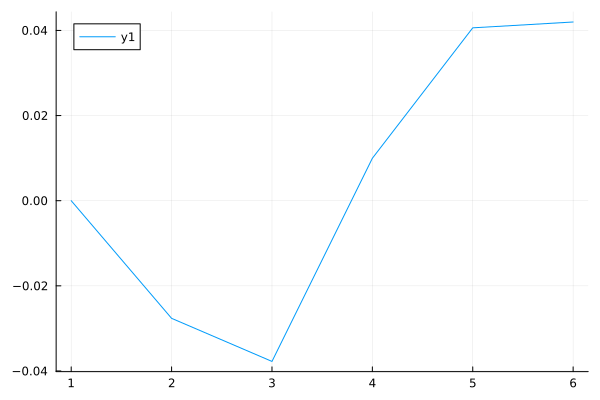

In [327]:
vz.(sol.u) |> plot

## Run a constant-diffusion simulation

In [333]:
@everywhere diffusion_constant = (sol.prob.p.sum_diffusion_x + sol.prob.p.sum_diffusion_y + sol.prob.p.sum_diffusion_z) / sol.prob.p.n_scatters / 3
display(diffusion_constant)
diffusion_constant = 0.0
;

LoadError: TaskFailedException

[91m    nested task error: [39mtype NamedTuple has no field sum_diffusion_x
    Stacktrace:
     [1] [0m[1mgetproperty[22m[0m[1m([22m[90mmnt[39m::[0mMutableNamedTuple[90m{(:H, :H₀, :∇H, :ψ, :dψ, :ψ_soa, :dψ_soa, :ω, :eiωt, :Js, :states, :fields, :r0, :r, :v, :d, :d_nnz, :λ, :k, :Γ, :E, :E_k, :ds, :ds_state1, :ds_state2, :sim_params, :extra_data, :mass, :update_H_and_∇H, :populations, :n_scatters, :save_counter, :n_states, :n_ground, :n_excited, :trajectory, :decay_dist, :time_to_decay, :last_decay_time, :diffusion_constant), Tuple{Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructVector{State{HundsCaseB_LinearMolecule}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{HundsCaseB_LinearMolecule}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructVector{Field{Float64, var"#279#284"{SVector{3, ComplexF64}}, var"#282#290"{Float64, Float64, Float64, Tuple{Int64, Int64}, Tuple{Float64, Float64}}}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{SVector{3, Float64}}, Vector{var"#279#284"{SVector{3, ComplexF64}}}, Vector{SVector{3, ComplexF64}}, Vector{Float64}, Vector{var"#282#290"{Float64, Float64, Float64, Tuple{Int64, Int64}, Tuple{Float64, Float64}}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{MVector{3, Float64}}, Base.RefValue{MVector{3, Float64}}, Base.RefValue{MVector{3, Float64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{Vector{SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{MutableNamedTuple{(:pol1_x, :pol2_x, :pol3_x, :pol4_x, :s1, :s2, :s3, :s4, :Δ1, :Δ2, :Δ3, :Δ4, :B_gradient, :B_offset, :B_ramp_time, :Bz_offset, :By_offset, :Bx_offset, :temp, :diameter, :s_ramp_time, :s_ramp_factor, :pol_imbalance, :s_imbalance, :retro_loss, :off_center, :pointing_error, :dt, :diffusion_constant, :photon_budget), Tuple{Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{SVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Tuple{Float64, Float64, Float64}}, Base.RefValue{Float64}, Base.RefValue{Vector{Float64}}, Base.RefValue{Vector{Int64}}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}}}}, Base.RefValue{MutableNamedTuple{(:Zeeman_Hx, :Zeeman_Hy, :Zeeman_Hz), Tuple{Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}}}}, Base.RefValue{Float64}, Base.RefValue{typeof(update_H_and_∇H)}, Base.RefValue{Vector{Float64}}, Base.RefValue{Int64}, Base.RefValue{Int64}, Base.RefValue{Int64}, Base.RefValue{Int64}, Base.RefValue{Int64}, Base.RefValue{Vector{Vector{ComplexF64}}}, Base.RefValue{Distributions.Exponential{Float64}}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}}}[39m, [90ms[39m::[0mSymbol[0m[1m)[22m
    [90m   @[39m [32mMutableNamedTuples[39m [90mC:\Users\halla\.julia\packages\MutableNamedTuples\3r0U8\src\[39m[90m[4mMutableNamedTuples.jl:27[24m[39m
     [2] top-level scope
    [90m   @[39m [90m[4mnone:1[24m[39m
     [3] [0m[1meval[22m
    [90m   @[39m [90m.\[39m[90m[4mboot.jl:370[24m[39m[90m [inlined][39m
     [4] [0m[1m(::Distributed.var"#172#174"{Module, Expr})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [36mDistributed[39m [90m.\[39m[90m[4mtask.jl:514[24m[39m

In [334]:
@everywhere begin
    t_start = 0.0
    t_end   = 5e-3
    t_span  = (t_start, t_end) ./ (1/Γ)

    ψ₀ = zeros(ComplexF64, length(states))
    ψ₀[1] = 1.0
    
    # set initial particle position
    r0 = [0., 0., 0.6e-3]
    particle.r = r0 ./ (1/k)
    p = schrodinger_stochastic_constant_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    p.diffusion_constant = diffusion_constant
    
    cb = ContinuousCallback(condition, SE_collapse_pol_constant_diffusion!, nothing, save_positions=(false,false))
    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p; callback=cb, reltol=5e-4, saveat=1000, maxiters=80000000)
end
@time sol = DifferentialEquations.solve(prob, alg=DP5(), progress=true, progress_steps=50000)
;

ODE   0%|█                                              |  ETA: N/A
ODE   7%|████                                           |  ETA: 0:00:10
ODE  15%|███████                                        |  ETA: 0:00:09
ODE  22%|███████████                                    |  ETA: 0:00:08
ODE  29%|██████████████                                 |  ETA: 0:00:08
ODE  36%|█████████████████                              |  ETA: 0:00:07
ODE  43%|█████████████████████                          |  ETA: 0:00:06
ODE  51%|████████████████████████                       |  ETA: 0:00:05
ODE  58%|████████████████████████████                   |  ETA: 0:00:05
ODE  65%|███████████████████████████████                |  ETA: 0:00:04
ODE  72%|██████████████████████████████████             |  ETA: 0:00:03
ODE  78%|█████████████████████████████████████          |  ETA: 0:00:03
ODE  84%|████████████████████████████████████████       |  ETA: 0:00:02
ODE  89%|██████████████████████████████████████████     |  ETA: 0:00

 12.044745 seconds (5.40 k allocations: 553.508 KiB)



ODE 100%|███████████████████████████████████████████████| Time: 0:00:12


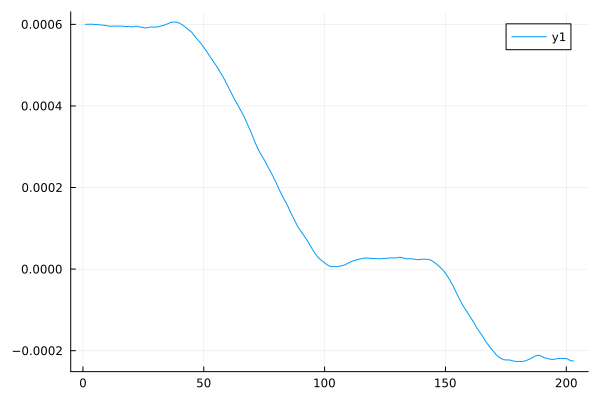

In [332]:
z.(sol.u) |> plot

## Simulate multiple particles

In [306]:
using Plots

In [307]:
@everywhere function prob_func(prob, i, repeat)
    
    t_start = 0.0
    t_end   = 5e-3
    t_span  = (t_start, t_end) ./ (1/Γ)
    
    extra_data = prob.p.extra_data
    sim_params = prob.p.sim_params

    # set initial particle position
    particle = Particle()
    r0 = [0., 0., 0.6e-3]
    particle.r = r0 ./ (1/k)

    ψ₀ = zeros(ComplexF64, length(states))
    ψ₀[1] = 1.0
    
    # define lasers
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_factor,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )

    d = prob.p.d
    n_excited = prob.p.n_excited
    
    p = schrodinger_stochastic_constant_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    p.diffusion_constant = diffusion_constant
    
    cb = ContinuousCallback(condition, SE_collapse_pol_constant_diffusion!, nothing, save_positions=(false,false))
    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p; callback=cb, reltol=5e-4, saveat=1000, maxiters=80000000)

    return prob
end;

In [272]:
ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleDistributed(); trajectories=20)
;

 37.300774 seconds (563.91 k allocations: 22.041 MiB, 0.09% gc time)


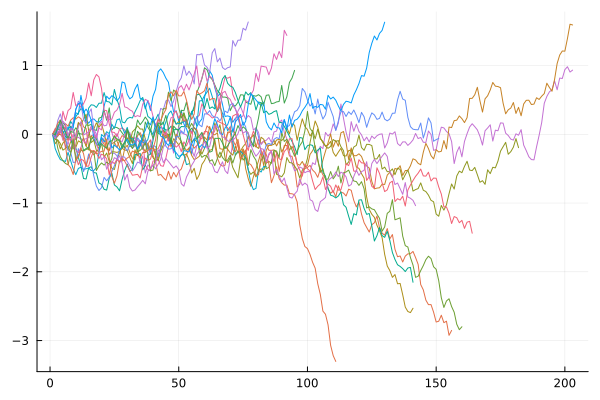

In [277]:
plot()
for sol ∈ ensemble_sol
    plot!(vz.(sol.u))
end
plot!(legend=nothing)

In [278]:
using StatsBase
mean([vz.(sol.u) for sol ∈ ensemble_sol]) |> plot

LoadError: DimensionMismatch: dimensions must match: a has dims (Base.OneTo(74),), b has dims (Base.OneTo(156),), mismatch at 1

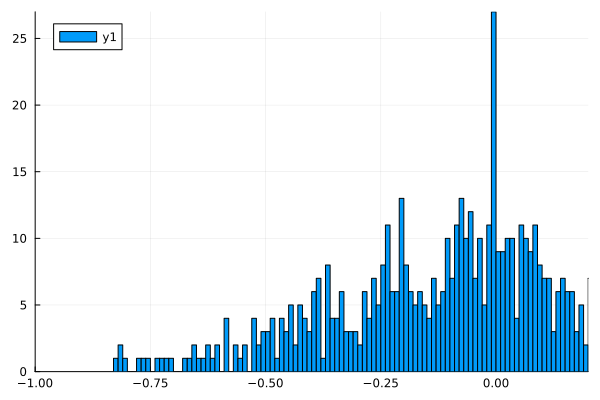

In [279]:
histogram(vcat([vz.(sol.u)[1:30] for sol ∈ ensemble_sol]...), xlim=(-1.0, 0.2), bins=300)

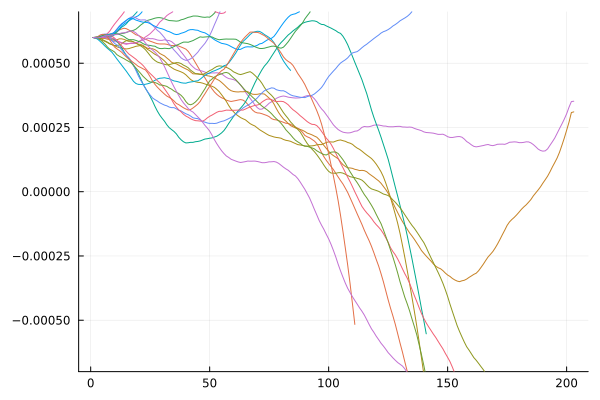

In [280]:
plot()
for sol ∈ ensemble_sol
    plot!(z.(sol.u))
end
plot!(
    legend=nothing,
    ylim=(-0.7e-3, +0.7e-3)
)

## Fitted size

In [24]:
survived(x,y,z) = sqrt(x^2+y^2+z^2) <= 0.5e-3

function size(ensemble_sol, idx)
    xs = Float64[]
    ys = Float64[]
    zs = Float64[]
    for i ∈ eachindex(ensemble_sol)
        sol = ensemble_sol[i]
        _x = x(sol.u[idx])
        _y = y(sol.u[idx])
        _z = z(sol.u[idx])
        if survived(_x,_y,_z)
            push!(xs, _x)
            push!(ys, _y)
            push!(zs, _z)
        end
    end
    return (std(xs) * std(ys) * std(zs))^(1/3)
end;

In [25]:
Δ4

8.35e6

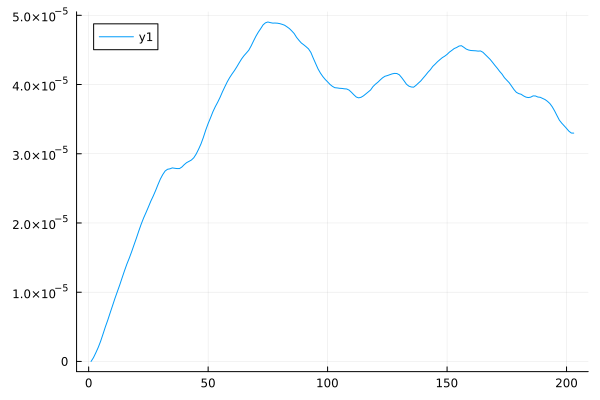

In [26]:
plot([size(ensemble_sol, i) for i ∈ eachindex(ensemble_sol[1].u)])

In [27]:
using LsqFit

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2))
end

function cloud_size_fitted(xs)

    hist_data = fit(Histogram, xs, -1e-3:1e-5:1e-3)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    # histogram(hist_data)
    
    v_fit = curve_fit(Gaussian, v, fv, [1e-5, 0., 5])
    σ, x0, A = v_fit.param
    
    # histogram!(xs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    return σ
end
;

In [28]:
xs = vcat([x.(sol.u)[end] for sol ∈ ensemble_sol]...)
ys = vcat([y.(sol.u)[end] for sol ∈ ensemble_sol]...)
zs = vcat([z.(sol.u)[end] for sol ∈ ensemble_sol]...)
;

In [29]:
cloud_size_fitted(zs)

-2.1532890290446325e-5

In [30]:
using StatsBase

3-element Vector{Float64}:
    -2.1532890290446325e-5
    -4.126096076292376e-6
 17851.06806122383

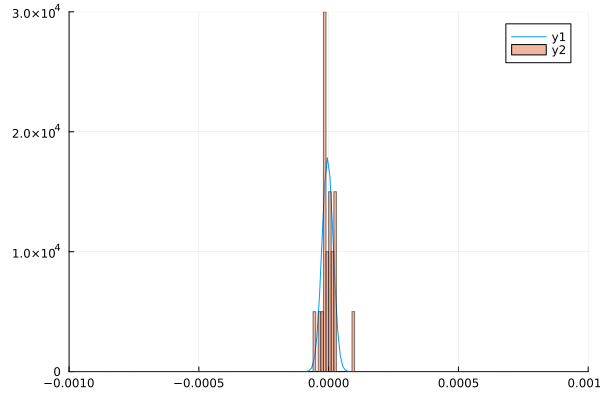

In [31]:
hist_data = fit(Histogram, zs, -1e-3:1e-5:1e-3)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [1e-5, 0., 5])
σ, x0, A = v_fit.param

display(v_fit.param)
plot(v, Gaussian(v, v_fit.param))
histogram!(zs, bins=hist_data.edges, xlim=(-1e-3, +1e-3), alpha=0.5, normalize=true)

In [32]:
cloud_sizes_x_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_x_trajectories]) for i ∈ eachindex(survived_x_trajectories[1])]
cloud_sizes_y_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_y_trajectories]) for i ∈ eachindex(survived_x_trajectories[1])]
cloud_sizes_z_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_z_trajectories]) for i ∈ eachindex(survived_x_trajectories[1])]
cloud_sizes_fitted = (abs.(cloud_sizes_x_fitted) .* abs.(cloud_sizes_y_fitted) .* abs.(cloud_sizes_z_fitted)).^(1/3)
;

LoadError: UndefVarError: `survived_x_trajectories` not defined

In [33]:
plot(survived_times[1], cloud_sizes_fitted, ylim=(0,1.0))
hline!([0.06])

LoadError: UndefVarError: `survived_times` not defined

## Fitted temperature

In [34]:
kB = 1.38e-23

velocities = [sqrt.(results.x_velocities[i].^2 .+ results.y_velocities[i].^2 .+ results.z_velocities[i].^2) for i ∈ survived_molecules];

function maxwell_boltzmann(v, p)
    A, T = p
    return A * ((m/(2π*kB*T))^(3/2) * 4π) .* v .^2 .* exp.(v .^2 .* (-m / (2*kB*T)))
end

# take velocities from t = 5 ms to t = 8 ms
vs = [[v[end-10:end] for v ∈ velocities]]
vs = vec(hcat(vs...))
vs = vec(hcat(vs...))
# vs = [[v[end-10] for v ∈ velocities]]
# vs = vec(hcat(vs...))

hist_data = fit(Histogram, vs, 0.0:0.04:1.0)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

histogram(hist_data)

v_fit = curve_fit(maxwell_boltzmann, v, fv, [4, 100e-6])
A, T = v_fit.param

display(v_fit.param)
plot(v, maxwell_boltzmann(v, v_fit.param))
histogram!(vs, bins=hist_data.edges, xlim=(0.0, 2.0), alpha=0.5, normalize=true)

LoadError: UndefVarError: `survived_molecules` not defined

In [35]:
T * 1e6

LoadError: MethodError: no method matching *(::typeof(T), ::Float64)

[0mClosest candidates are:
[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m)
[0m[90m   @[39m [90mBase[39m [90m[4moperators.jl:578[24m[39m
[0m  *([91m::T[39m, ::T) where T<:Union{Float16, Float32, Float64}
[0m[90m   @[39m [90mBase[39m [90m[4mfloat.jl:410[24m[39m
[0m  *([91m::StridedArray{P}[39m, ::Real) where P<:Dates.Period
[0m[90m   @[39m [35mDates[39m [90mC:\Users\halla\AppData\Local\Programs\Julia-1.9.1\share\julia\stdlib\v1.9\Dates\src\[39m[90m[4mdeprecated.jl:44[24m[39m
[0m  ...


In [36]:
function fit_temperature(vs)

    hist_data = fit(Histogram, vs, 0.0:0.04:2.0)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    histogram(hist_data)
    
    v_fit = curve_fit(maxwell_boltzmann, v, fv, [4, 100e-6])
    A, T = v_fit.param
    
    # histogram!(vs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    
    return T
end
;

In [37]:
fit_temperature([v[end-15] for v ∈ velocities]) * 1e6

LoadError: UndefVarError: `velocities` not defined